# Experiments

In [1]:
import pandas as pd
from blocksnet.enums import LandUse

FEATURES_COLS = ['footprint_area', 'build_floor_area']
ADDITIONAL_COLS = [lu.value for lu in LandUse]

In [ ]:
import os
from tqdm import tqdm
from metrics import evaluate_metrics
from imputers import MeanImputer, SknnImputer, IdwImputer, SmvNmfImputer, SmImputer

N_STEPS = 9
N_RUNS = 100

results = []

for file_name in ['saint_petersburg.pickle']: # os.listdir('./data'):
    city_name = file_name.split('.')[0]

    blocks_gdf = pd.read_pickle(f'./data/{file_name}')
    blocks_gdf['site_area'] = blocks_gdf.area

    imputers = {
        'mean': MeanImputer(blocks_gdf, FEATURES_COLS),
        'sknn': SknnImputer(blocks_gdf, FEATURES_COLS),
        'idw': IdwImputer(blocks_gdf, FEATURES_COLS),
        'smv-nmf': SmvNmfImputer(blocks_gdf, FEATURES_COLS, additional_cols=ADDITIONAL_COLS),
        'sm': SmImputer(blocks_gdf, FEATURES_COLS, additional_cols=ADDITIONAL_COLS)
    }

    for i in range(N_STEPS):

        missing_rate = round(0.1 * (i+1),1)
        n = int(len(blocks_gdf)*missing_rate)

        for _ in tqdm(range(N_RUNS), desc=f'{missing_rate}'):

            blocks_ids = blocks_gdf.sample(n).index.to_list()
            true_df = blocks_gdf.loc[blocks_ids, FEATURES_COLS].copy()

            for name,imputer in imputers.items():
                pred_df = imputer.impute(blocks_ids)
                results_dicts = evaluate_metrics(true_df, pred_df)
                for result_dict in results_dicts:
                    result_dict.update({
                        'method': name,
                        'missing_rate': missing_rate,
                        'city': city_name
                    })
                results.extend(results_dicts)


0.2:  86%|████████▌ | 86/100 [21:44<03:19, 14.28s/it]/home/vasilstar/sm-imputation/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
0.3:  64%|██████▍   | 64/100 [19:34<10:40, 17.78s/it]/home/vasilstar/sm-imputation/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
0.6:  97%|█████████▋| 97/100 [32:34<01:01, 20.61s/it]

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()

,feature,mae,rmse,r2,r2_robust,method,missing_rate,city
0,footprint_area,5561.798669,12679.750164,-0.000232,0.098385,mean,0.1,helsinki
1,build_floor_area,14486.756437,34680.659870,-0.000972,0.206206,mean,0.1,helsinki
2,footprint_area,4644.485127,13483.595527,-0.131073,0.915129,sknn,0.1,helsinki
3,build_floor_area,12280.343786,36290.629902,-0.096065,0.953220,sknn,0.1,helsinki
4,footprint_area,4248.202090,13213.858212,-0.086272,0.988526,idw,0.1,helsinki


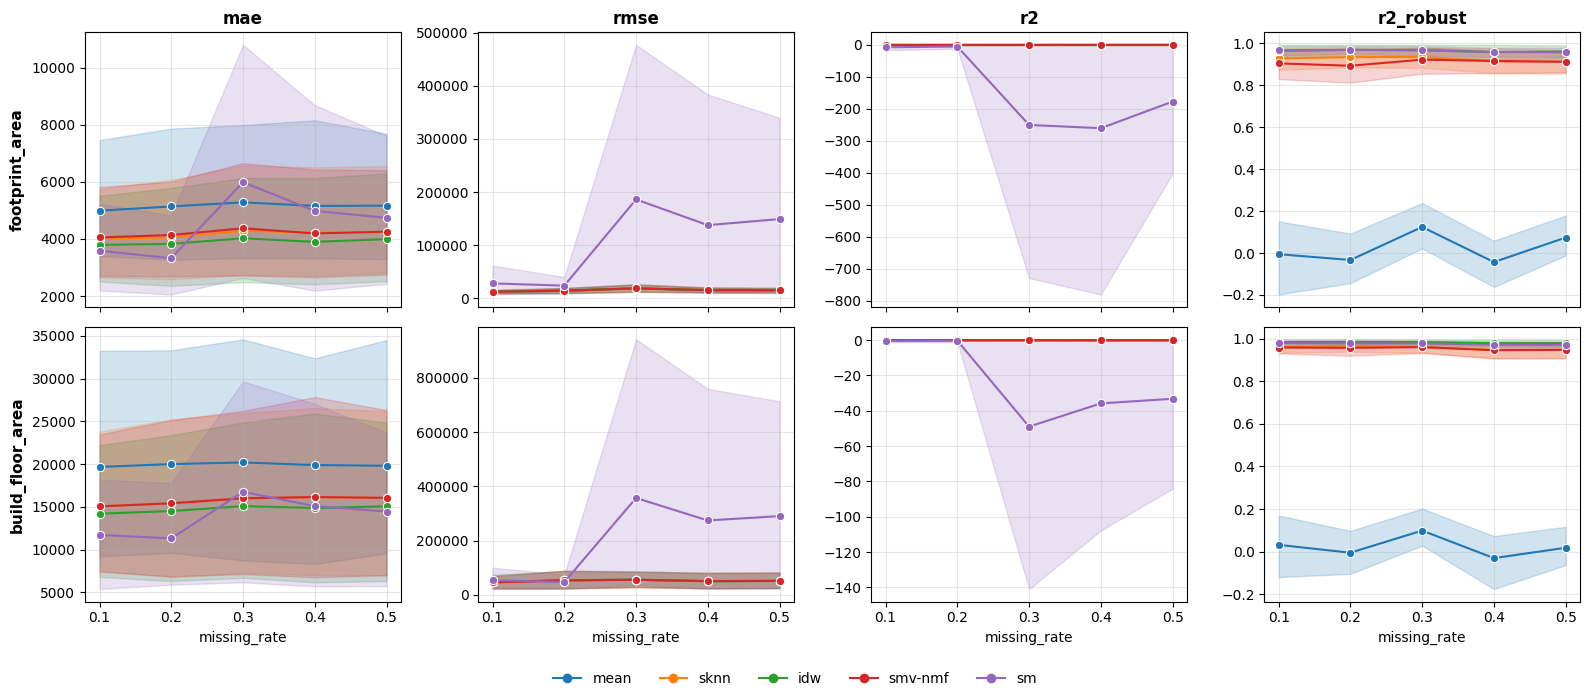

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['mae', 'rmse', 'r2', 'r2_robust']
features = results_df['feature'].unique()
methods = results_df.method.unique()
palette = sns.color_palette("tab10", n_colors=len(methods))

n_rows = len(features)
n_cols = len(metrics)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex='col', sharey=False
)

for i, feature in enumerate(features):
    sub = results_df[results_df['feature'] == feature]
    for j, metric in enumerate(metrics):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        sns.lineplot(
            data=sub,
            x='missing_rate',
            y=metric,
            hue='method',
            marker='o',
            ax=ax,
            palette=palette,
            legend=False 
        )
        if i == 0:
            ax.set_title(metric, fontsize=12, weight='bold')
        if j == 0:
            ax.set_ylabel(feature, fontsize=11, weight='bold')
        else:
            ax.set_ylabel('')
        if i != n_rows - 1:
            ax.set_xlabel('')
        ax.grid(True, alpha=0.3)

handles = [plt.Line2D([0], [0], color=palette[i], marker='o', label=meth) 
           for i, meth in enumerate(methods)]
labels = methods
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
